In [31]:
import pygplates
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions
import pygmt
import numpy as np
import geopandas as gpd
#from shapely.geometry import LineString, Polygon, Point
from gprm.utils.deformation import geodataframe_topological_reconstruction, topological_reconstruction
import pandas as pd
import xarray as xr

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
M2019 = Reconstructions.fetch_Muller2019()


In [4]:
topological_model = pygplates.TopologicalModel(
            M2019.dynamic_polygons,
            M2019.rotation_model,
            # Enable strain rate clamping to better control crustal stretching factors...
            default_resolve_topology_parameters=pygplates.ResolveTopologyParameters(enable_strain_rate_clamping=True))


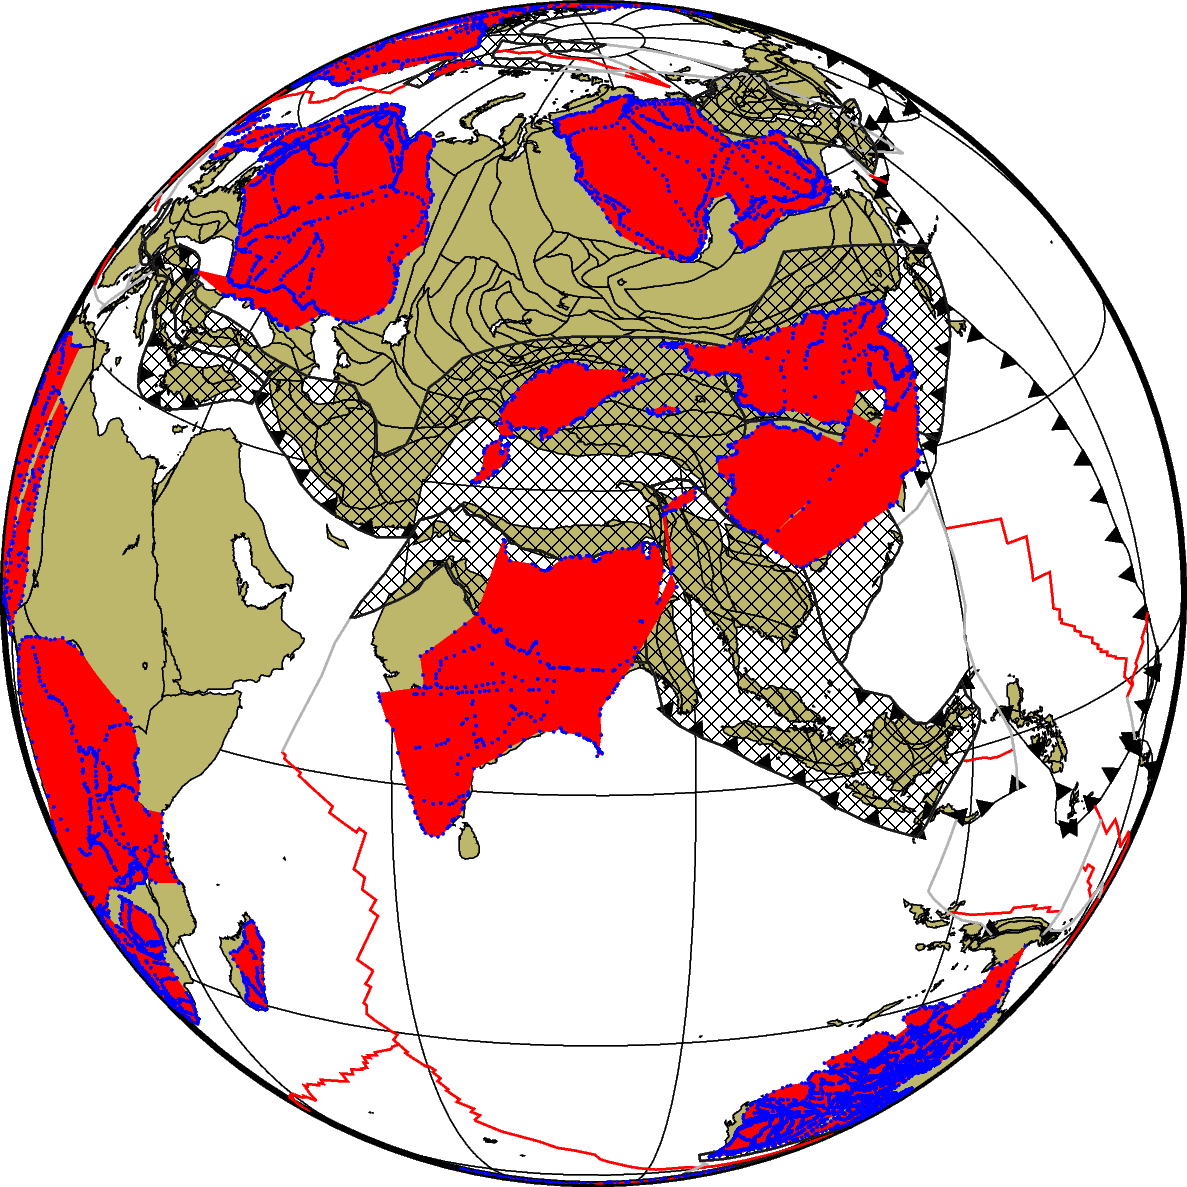

In [6]:
#gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

gdf = gpd.read_file('/Users/simon/GIT/gpdata/reconstructions/PEHRSSON2015/PlatePolygons.shp')

reconstruction_time = 35.

result = geodataframe_topological_reconstruction(gdf, topological_model, reconstruction_time,
                                                 deactivate_points=None)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G80/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
#fig.plot(x=result.geometry.x, y=result.geometry.y, style='c0.1c', color='red')

fig.plot(data=result, color='red')
fig.plot(data=result, style='c0.025c', color='blue')

#result.to_file('tmp.gmt', driver='OGR_GMT')
#fig.plot(data='tmp.gmt', color='red')
#fig.plot(data='tmp.gmt', style='c0.025c', color='blue')

fig.show(width=800)


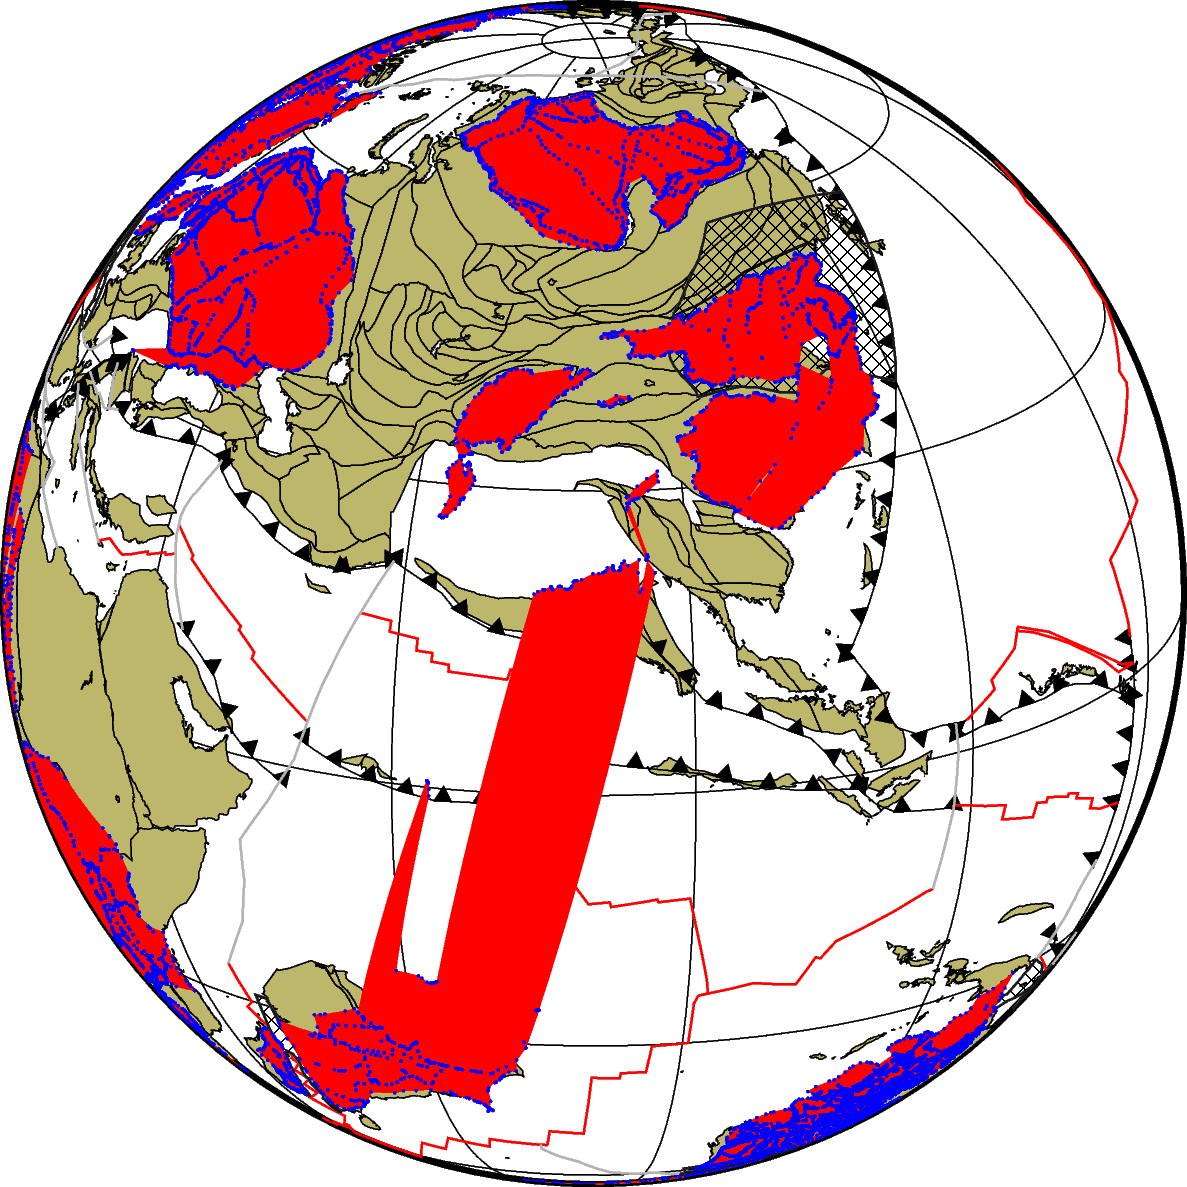

In [7]:
#gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

gdf = gpd.read_file('/Users/simon/GIT/gpdata/reconstructions/PEHRSSON2015/PlatePolygons.shp')

reconstruction_time = 85.

result = geodataframe_topological_reconstruction(gdf, topological_model, reconstruction_time,
                                                 deactivate_points=None)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G80/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
#fig.plot(x=result.geometry.x, y=result.geometry.y, style='c0.1c', color='red')

fig.plot(data=result, color='red')
fig.plot(data=result, style='c0.025c', color='blue')

#result.to_file('tmp.gmt', driver='OGR_GMT')
#fig.plot(data='tmp.gmt', color='red')
#fig.plot(data='tmp.gmt', style='c0.025c', color='blue')

fig.show(width=800)


In [35]:
from gprm.utils.raster import xyz2grd


def raster_topological_reconstruction(grid, topological_model, reconstruction_time, reverse=True):
    
    XX,YY = np.meshgrid(grid.lon.data, grid.lat.data)

    geometry_points = [(lat,lon) for lat,lon in zip(YY.flatten(),XX.flatten())]

    if reverse:
        pts, valid_index = topological_reconstruction(topological_model, geometry_points, 0., initial_time=reconstruction_time, oldest_time=reconstruction_time, 
                                                      return_inactive_points=True, deactivate_points=False)

        res = pygmt.grdtrack(grid=grid, 
                             points=pd.DataFrame(data={'x':pts[1],'y':pts[0]}), newcolname='z')
        x=XX.flatten()[valid_index] 
        y=YY.flatten()[valid_index]

        resg = xyz2grd(x,y,np.array(res['z']),XX,YY)
        
        reconstructed_raster = xr.DataArray(resg, coords=[('lat',grid.lat.data), ('lon',grid.lon.data)], name='z')
        
        return reconstructed_raster
    
    else:
        pts, valid_index = topological_reconstruction(topological_model, geometry_points, reconstruction_time, 
                                                      return_inactive_points=True, deactivate_points=False)

        return pts, grid.data.flatten()[valid_index]
    
    

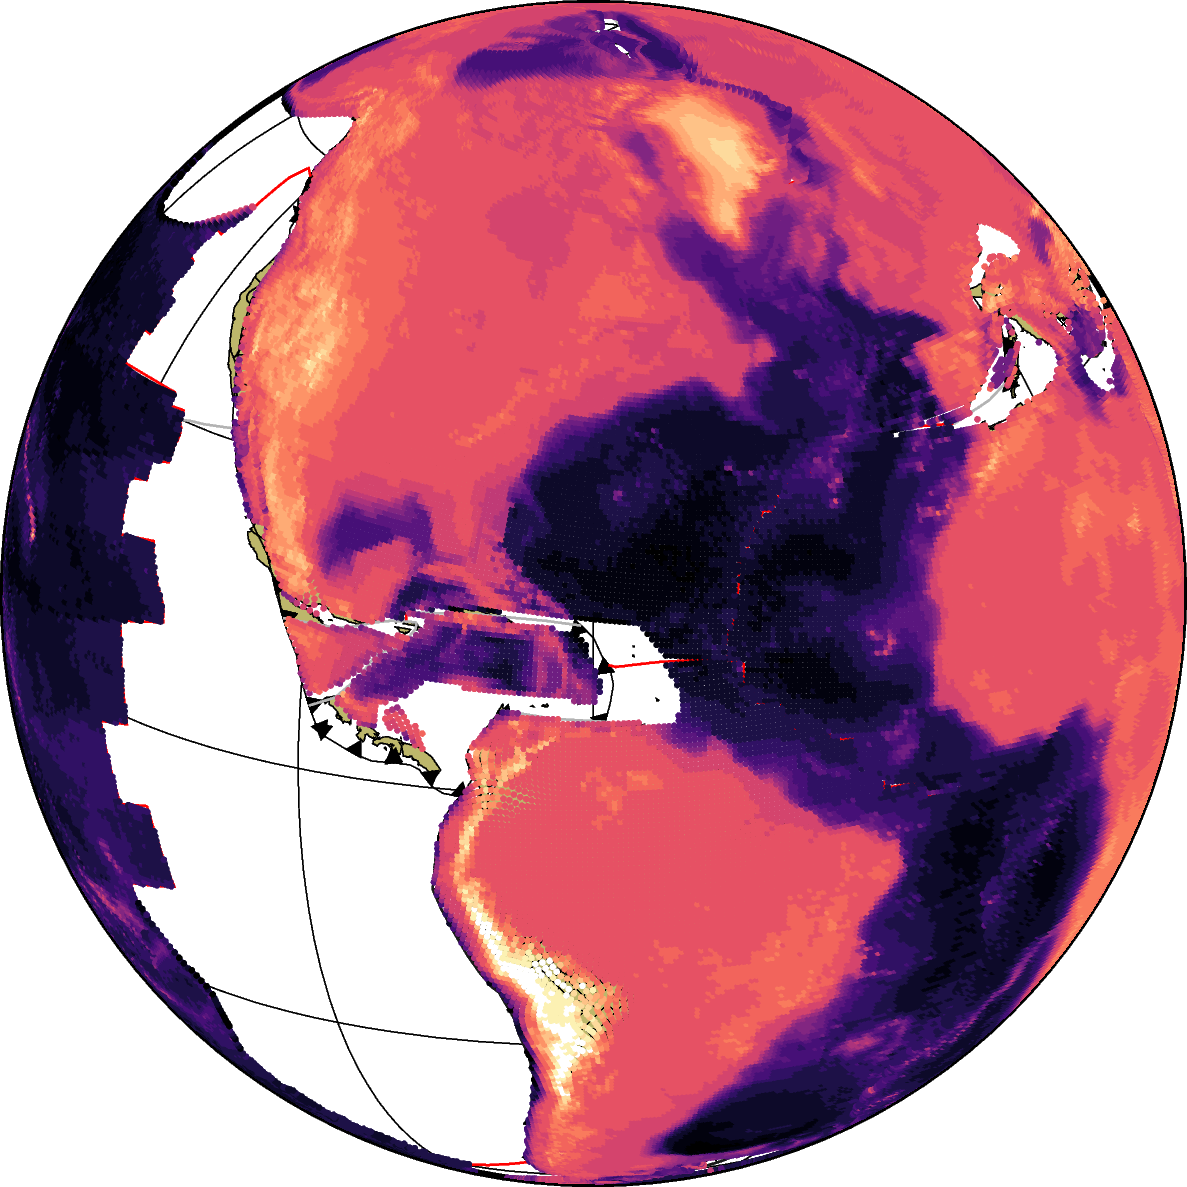

In [33]:
# Two ways to do raster reconstruction via topologies
#
# 1. Take the regular grid points at present-day, and reconstruct them
#    backwards. This way, the reconstructed points are not aligned to the
#    regular grid so would need to be re-interpolated


reconstruction_time = 40.
grid = pygmt.datasets.load_earth_relief(region='d', resolution='30m', registration='gridline')

pts,zvals = raster_topological_reconstruction(grid, topological_model, reconstruction_time, reverse=False)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)


fig = pygmt.Figure()
fig.basemap(region='d', projection='G-60/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
pygmt.makecpt(cmap='magma', series=[-6000,4000,500])
fig.plot(x=pts[1], y=pts[0], style='c0.05c', color=zvals, cmap=True)

fig.show(width=800)

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


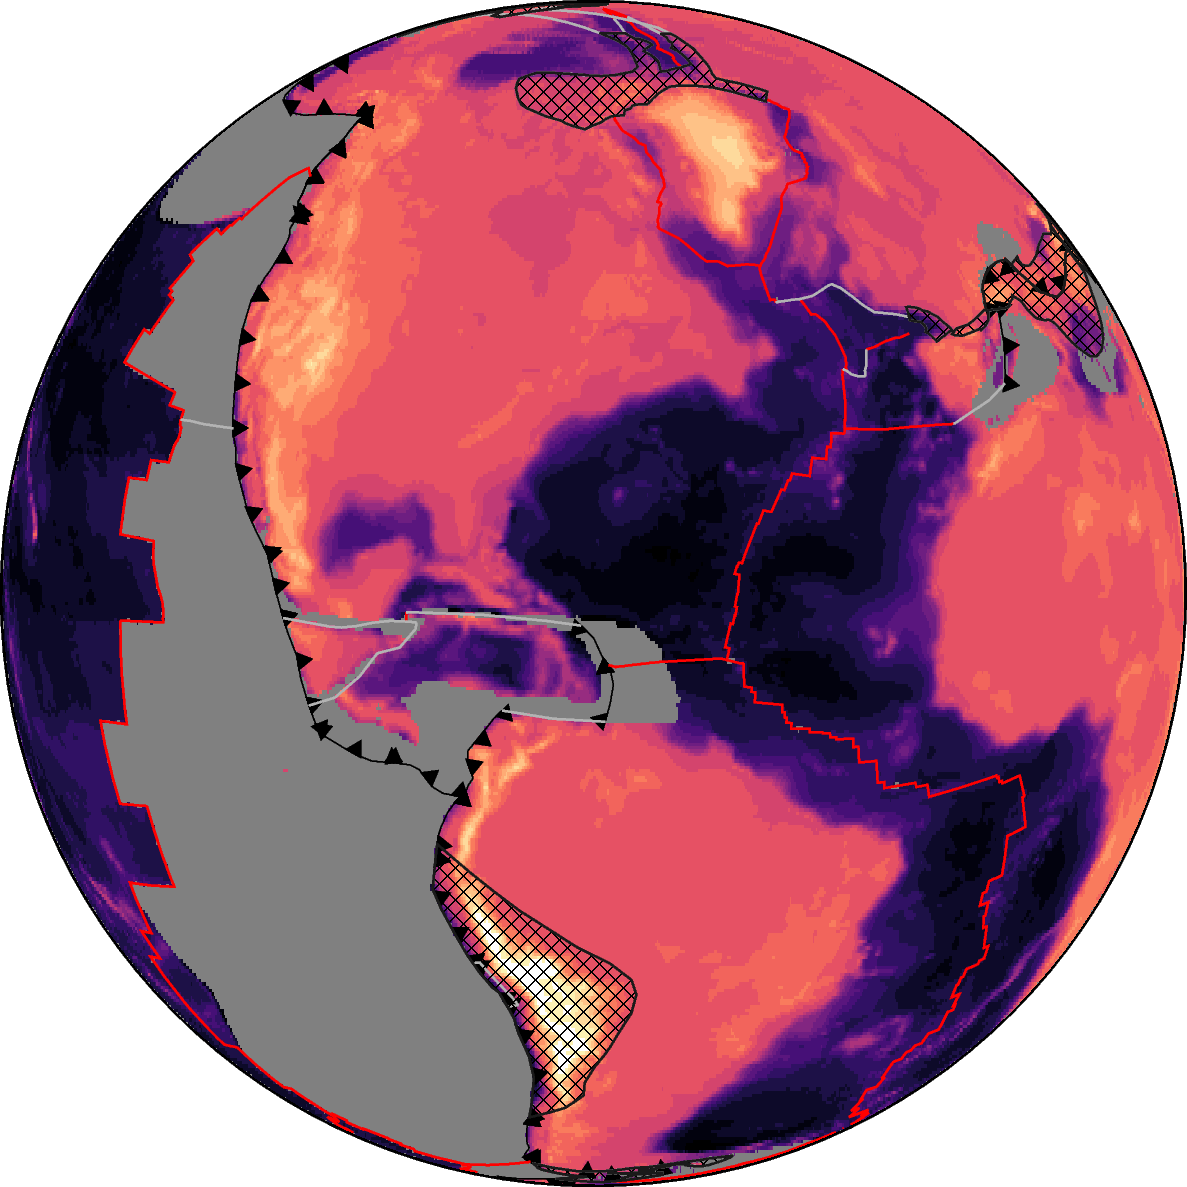

In [38]:
# 2. Take the regular grid points at the reconstruction time and unreconstruct them to present
#    day, then sample the raster values. This way, the sampled values can be assigned to 
#    points that are already on a regular grid at the reconstruction time. So we can then
#    create a grid-object and display with grdimage (or save to netcdf)


reconstruction_time = 40.
grid = pygmt.datasets.load_earth_relief(region='d', resolution='30m', registration='gridline')


resg = raster_topological_reconstruction(grid, topological_model, reconstruction_time)

#print(type(zvals))
#write_netcdf_grid('test.nc', grid.lon.data, grid.lat.data, resg, format='NETCDF4_CLASSIC')

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G-60/20/10c', frame='afg')
#fig.coast(land='gray')
#reconstructed_continents.plot(fig, color='darkkhaki')

pygmt.makecpt(cmap='magma', series=[-6000,4000,500])
fig.grdimage(grid=resg, cmap=True)

reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

#fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')

#fig.plot(x=XX.flatten()[valid_index], y=YY.flatten()[valid_index], style='c0.025c', color=zvals, cmap=True)
#fig.grdimage(grid=resg, cmap=True)
fig.show(width=800)
